In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


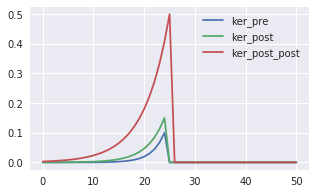

In [82]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()
ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=5, scale=0.1)
ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=7, scale=0.15)
ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=10, scale=0.5,shift=-1)
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.plot(ker_test.kernel_post_post, label='ker_post_post')
plt.legend()

In [83]:
ker_test.kernel_post_post[27]

array([ 0.])

In [84]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [85]:
# Drop long protocl that can be replaced by STDP
data.drop(data[data['ptl_occ'] == 50].index, axis=0, inplace=True)

In [86]:
data[data['ptl_idx'] == 5]

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
144,5,5,10,5,10,15,0.1,10.0,0.0,0,115.724663,9.195363,150.0
145,5,5,20,5,20,15,0.1,10.0,0.0,0,131.265503,12.873509,150.0
146,5,5,40,5,40,15,0.1,10.0,0.0,0,154.160944,10.114900,150.0
147,5,5,50,5,50,15,0.1,10.0,0.0,0,156.368508,25.747018,150.0


In [87]:
# Generate data
ptl_list = [1,5,6,7,8]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data_select[data_select['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)

# for i in range(len(dt)):
#     if np.abs(dt[i])>10:
#         new_try2 = data_select[data_select['ptl_idx']==3].iloc[0]
#         new_try2['dt2'] = dt[i]
#         data_select = data_select.append(new_try2, ignore_index=True)
    
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data_select, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[5,20,20,20,20], net_type='triplet')

In [88]:
spk_pairs.shape

(1105, 75000, 2)

In [89]:
# Create the network
ground_truth_init = 0
toy_data_net2 = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])

In [90]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/TripNet_ptl1_toy'
toy_net2_trainer = trainer.Trainer(toy_data_net2.loss, input_name=toy_data_net2.inputs, target_name=toy_data_net2.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net2.lr})

In [91]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


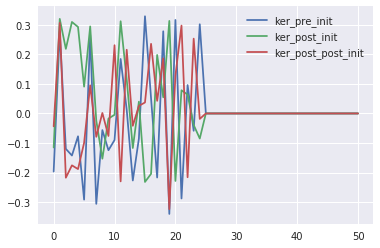

In [92]:
w_pre = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_pre)
w_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post)
w_post_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post_post)
plt.plot(w_pre, label='ker_pre_init')
plt.plot(w_post, label='ker_post_init')
plt.plot(w_post_post, label='ker_post_post_init')
# bias = toy_net2_trainer.evaluate(ops=toy_data_net2.bias)
plt.legend()
# bias

In [ ]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net2_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net2.lr: learning_rate})
    learning_rate = learning_rate/3


Initial validation cost=41.23444
Global Step 0150 and Step 0150: validation cost=13.04993
Updated min validation loss!Saving model...
Global Step 0200 and Step 0200: validation cost=9.74586
Updated min validation loss!Saving model...
Global Step 0250 and Step 0250: validation cost=7.45058
Updated min validation loss!Saving model...
Global Step 0300 and Step 0300: validation cost=5.82235
Updated min validation loss!Saving model...


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


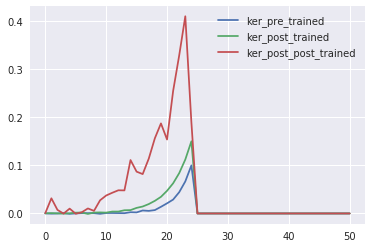

In [35]:
w_pre = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_pre)
w_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post)
w_post_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post_post)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.plot(w_post_post, label='ker_post_post_trained')
plt.legend()

In [37]:
w_post_post[24]

array([ 0.18948211], dtype=float32)